# Table of Contents

## 1) Data Loading
## 2) Preprocessing with gensim
## 3) Lemmatize with spacy
## 4) Vectorize

In [1]:
import re, nltk, spacy, gensim, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib

#### load all files in directory
- <code>listdir</code>: make a list of files in the directory

- <code>join</code>: join the path and filename string ("//" is automatically inserted)

- <code>open</code>: TextWrapper Object, loadable by <code>json.load()</code>

- <code>json.load()</code>: load jsonfile into dictionary object
<code></code>

## 1) Data Loading

In [2]:
from os import listdir
from os.path import isfile, join

import json

mypath = "/home/yuvenious/election_tweets"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

archive_path1 = "./Archive/"
archive_path2 = "./Archive/Topic Modeling"

In [3]:
start = time.time()
all_tweets = []
for i, jfile in enumerate(onlyfiles[:]):
    fullpath = join(mypath, jfile)
    print(i, "%s started"%jfile)
    start = time.time()
        
    with open(fullpath, "r") as f:
        data = json.load(f)
        text_dict = {}
        for tweet in data:
            id_in_keys = "id" in tweet.keys()
            text_in_keys = "text" in tweet.keys()
            if id_in_keys & text_in_keys:
                text_none = tweet["text"] == None
                if not text_none:
                    text_dict[tweet["id"]] = tweet["text"]
        np.save(archive_path1+"election_tweets%s.npy"%i, text_dict)
        print(i, "%s saved"%jfile)
    end = time.time()
    print(i, "%s finished"%jfile, len(text_dict), round(end-start, 2), "sec")

0 full_tweet_non_english2202.json started
0 full_tweet_non_english2202.json saved
0 full_tweet_non_english2202.json finished 54080 5.29 sec
1 full_tweet_non_english2303.json started
1 full_tweet_non_english2303.json saved
1 full_tweet_non_english2303.json finished 131629 12.14 sec
2 full_tweet_non_english5303.json started
2 full_tweet_non_english5303.json saved
2 full_tweet_non_english5303.json finished 115525 10.31 sec
3 full_tweet_non_english3303.json started
3 full_tweet_non_english3303.json saved
3 full_tweet_non_english3303.json finished 135285 12.18 sec
4 full_tweet_non_english4303.json started
4 full_tweet_non_english4303.json saved
4 full_tweet_non_english4303.json finished 146090 11.46 sec
5 full_tweet_non_english1202.json started
5 full_tweet_non_english1202.json saved
5 full_tweet_non_english1202.json finished 96057 9.13 sec
6 full_tweet_non_english6303.json started
6 full_tweet_non_english6303.json saved
6 full_tweet_non_english6303.json finished 21682 2.52 sec
7 full_tweet

In [4]:
all_tweets = {}
for i in range(len(onlyfiles)):
    dict_path = archive_path1+"election_tweets%s.npy"%i
    tweets = np.load(dict_path).item()
    all_tweets.update(tweets)
len(all_tweets)

795867

## 2) Pre-Processing with Gensim

In [5]:
def sent_to_words(sentences):
    total_length = len(sentences)
    perc = int(total_length/10)
    for i, s in enumerate(sentences):
        if i%perc == 0:
            print(round(i/total_length*100),"%")
        yield gensim.utils.simple_preprocess(s, deacc=True, min_len = 2) # deacc=True removes punctuations

start = time.time()
text_list = list(all_tweets.values())
data_words = list(sent_to_words(text_list))
end = time.time()

print(end-start, "seconds")

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
37.616997480392456 seconds


In [6]:
len(data_words)

795867

## 2) Lemmatize with Spacy
### Requires cumstomizing for this project.
- some parties' name only consists of 2 letters ('gl', 'sp', 'cu') -> must "survive"
- POS(part-of-speech) is required (to drop conjuctive, such as "maar")
- parser is not required (not dependency, only words per se)
- ner is required, but not works well with Dutch language

In [7]:
def lemmatization(sents, redundant_words=["https", "rt", "niet", "er", 'is', "ee", "maar", "wil"],
                  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'],
                  language="nl", disable=['parser', 'ner', 'textcat']):
    
    short_names = ["gl", "sp", "cu"]
    redundant_words = redundant_words
    allowed_postags = allowed_postags
    if language == "nl":
        lang = 'nl_core_news_sm'
    elif language == "en":
        lang = 'en_core_news_sm'
    nlp = spacy.load(lang, disable=disable)

    perc = int(len(sents)/10)
    start = time.time()

    texts_out = []
    for i, sent in enumerate(sents):
        # counter
        if (i%perc == 0) & (i != 0):
            end = time.time()
            print(round((end-start)/60, 1), "minutes")
        # processing
        sent = [word for word in sent if "_" not in word] #exclude id
        doc = nlp(" ".join(sent))
        new_sent = []
        for token in doc:
            # longer than 3 words (but short parties name, "gl", "sp", "cu")
            longer_three = (len(token.text) > 2) | (token.text in short_names)
            # exclusive pos tags
            ex_pron = token.pos_ in allowed_postags
            # redundant words
            red_word = token.text not in redundant_words
            # pvv, vvd, fvd, etc. inside words            
            if longer_three & ex_pron & red_word:
                new_sent.extend([token.text])
        texts_out.append(" ".join(new_sent))
    return texts_out

In [8]:
# Test trial
data_lemmatized = lemmatization(data_words[:5000])

0.0 minutes
0.0 minutes
0.1 minutes
0.1 minutes
0.1 minutes
0.1 minutes
0.2 minutes
0.2 minutes
0.2 minutes


In [9]:
data_lemmatized[:20]

['joostvandegoor fvdemocratie kajsaollongren tponl had ooit kunnen vermoeden nederland zou worden opgezadeld',
 'gerbstruik zolang ollongren gesteund weet kabinet vvd bereid stellen kan ollong',
 'fvdemocratie kajsaollongren tponl ollongren gaan eentje wordt brussel doo',
 'minister kajsaollongren gaat aangenomen moties rutte uitslag referendum bedoel',
 'fredericootje kan ook hersencel marijnbosman abdeluhebchoho amsterdam uitleggen euep',
 'pvda kan meedenken gemeenteraad pvda sittard geleen heeft xzfpbl',
 'doet nooit had correctief referendum daarom mierlo dreigt',
 'eppobruins christenunie stemt versoepeling europese bonusregels financiele sector',
 'vvd oude ijsselstreek richard lange financien economie tiynad youtube',
 'fvd huichelachtig partijleider gewoon chat nvu lid openbaarheid komt',
 'driessewout duidelijker kan ollongren heeft democratie heeft democratie olllongren democrat',
 'ddstandaard lezen onthulling yernaz erbij genaaid ers waarvan kandidaat vvd htt',
 'wierdduk 

    "fvdamsterdam", "pvdaalkmaar" -> needs to be extracted

In [10]:
data_lemmatized = lemmatization(data_words)

4.0 minutes
8.0 minutes
12.1 minutes
16.2 minutes
20.3 minutes
24.3 minutes
28.3 minutes
32.3 minutes
36.3 minutes
40.2 minutes


In [11]:
#old laptop
# data_lemmatized = lemmatization(data_words)

    10.1 minutes
    21.5 minutes
    32.6 minutes
    43.1 minutes
    54.8 minutes
    66.0 minutes
    76.7 minutes
    87.0 minutes
    97.1 minutes
    107.3 minutes

In [12]:
pd.DataFrame(data_lemmatized, index = all_tweets.keys()).to_csv(archive_path2+"lemmatized.csv")
len(data_lemmatized)

795867

In [13]:
data_lemmatized = pd.read_csv("lemmatized.csv", index_col=0).dropna()
ids = data_lemmatized.index
data_lemmatized = data_lemmatized.values
len(data_lemmatized)

795548

after lematization, 319 tweets(795,867 - 795,548) are not relevant

### Extract some keywords, for example:
- <code>fvdamsterdam</code> -> fvd amsterdam
- <code>pvdaalkmaar</code> -> pvd aalkmaar
- <code>fvdemocratie</code> -> fvd
- <code>geertwilderspvv</code> -> geert wilders pvv
- <code>groen links</code>-> groenlinks
- <code>theirrybaudet</code>-> theirry baudet
- <code>apechtold</code> -> pechtold

In [14]:
def decompose_kw(sen,
                 kws = ['vvd', 'pvv', 'cda', 'd66', 'pvda', 'pvdd', '50+', 'sgp', 'denk', 'fvd', "pvda",
                        "geert", "wilders", "rutte",
                        "baudet", "zijlstra", "ollongren"]):
    in_kws = []
    for kw in kws:
        if kw in sen:
            in_kws.append(kw)

    for kw in in_kws:
        sen = re.sub(kw, " "+kw+" ", sen)

    if "emocratie" in sen:
        sen = re.sub("emocratie", "", sen)
    
    if "groen links" in sen:
        sen = re.sub("groen links", "groenlinks", sen)
    
    if "apechtold" in sen:
        sen = re.sub("apechtold", "pechtold", sen)
    
    return " ".join(sen.split())

sen = 'theirrybaudet apechtold geertwilderspvv groen links pvdaalkmaar maarten staat nummer kandidatenlijst gelooft talenten heeft ontwik'
print(sen)
decompose_kw(sen)

theirrybaudet apechtold geertwilderspvv groen links pvdaalkmaar maarten staat nummer kandidatenlijst gelooft talenten heeft ontwik


'theirry baudet pechtold geert wilders pvv groenlinks pvda alkmaar maarten staat nummer kandidatenlijst gelooft talenten heeft ontwik'

In [15]:
start = time.time()
sentence_list = data_lemmatized.flatten().tolist()
for i, sen in enumerate(sentence_list):
    sentence_list[i] = decompose_kw(sen)
end = time.time()
print(round(end-start, 2), "sec")

2.96 sec


In [16]:
pd.DataFrame(sentence_list, index = ids).to_csv(archive_path2+"sentence_list.csv")

In [17]:
sentence_list = pd.read_csv(archive_path2+"sentence_list.csv", index_col=0)
sentence_list = sentence_list.values.flatten().tolist()

### 4) Vectorize data

In [18]:
freq_req = int(len(sentence_list)/100)
freq_req = 500

print("occur more than %s times"%freq_req)
l = []
for s in sentence_list:
    l.extend(s.split())
l = pd.Series(l).value_counts()
l = l[l >= freq_req]
l.sort_index(inplace=True)
# l = l[:-11] #japanese???
df = pd.DataFrame(columns=l.index)
df

occur more than 500 times


,aan,aandacht,aangenomen,aangepakt,aangifte,aanhang,aanhanger,aanleggen,aanpak,aanpakken,...,という野党の主張は的外れ,を作り,トントン暴かれて行く,会話文の途中にはさむ動作表d,作家あるある,拡散希望rtお願いします,昭恵婦人か絡んているから,本件の,森友問題,特殊性


In [19]:
l.sort_index().tail(12)

zwolle            1223
お話を受けまして          8249
という野党の主張は的外れ       524
を作り               8249
トントン暴かれて行く         524
会話文の途中にはさむ動作表d    8252
作家あるある            8249
拡散希望rtお願いします       524
昭恵婦人か絡んているから       524
本件の                524
森友問題               524
特殊性                524
dtype: int64

In [20]:
freq_req = 500

print("occur more than %s times"%freq_req)
l = []
for s in sentence_list:
    l.extend(s.split())
l = pd.Series(l).value_counts()
l = l[l >= freq_req]
l.sort_index(inplace=True)
l = l[:-11]
df = pd.DataFrame(columns=l.index)
df

occur more than 500 times


,aan,aandacht,aangenomen,aangepakt,aangifte,aanhang,aanhanger,aanleggen,aanpak,aanpakken,...,zoveelste,zover,zuid,zuidplas,zullen,zwaar,zwart,zwarte,zwijgt,zwolle


(0, 25000)

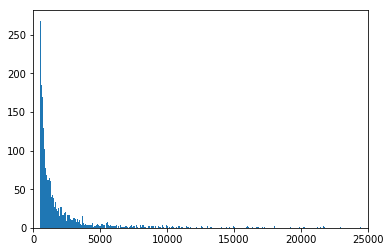

In [21]:
plt.hist(l, bins = 2000)
plt.xlim(0,25000)

In [22]:
for q in [0.7, 0.8, 0.9]:
    print(l.quantile(q))

1750.2999999999997
2606.6000000000004
4809.600000000001


In [23]:
freq_req = 2500

In [24]:
print("occur more than %s times"%freq_req)
l = []
for s in sentence_list:
    l.extend(s.split())
l = pd.Series(l).value_counts()
l = l[l >= freq_req]
l.sort_index(inplace=True)
l = l[:-11]
df = pd.DataFrame(columns=l.index)
df

occur more than 2500 times


,aan,aangifte,afgelopen,afschaffen,alexander,alleen,almere,altijd,amp,amsterdam,...,zeker,zelfs,zet,zetels,zetten,zie,zien,ziet,zijlstra,zijn


### Top 20 words (out of 403 words)

In [25]:
l.sort_values(ascending=False).head(20)

vvd           162214
pvv            85990
cda            74938
pvda           73040
pechtold       65022
fvd            62416
ook            54117
baudet         53146
zijn           43045
rutte          40103
heeft          39821
nog            37967
groenlinks     37697
stem           36656
wilders        35727
denk           33650
partij         32635
referendum     32106
geert          30583
thierry        30513
dtype: int64

In [26]:
func = lambda word, sentence: np.count_nonzero(np.array(sentence.split()) == word)
vfunc = np.vectorize(func)

data = data_lemmatized[:1000]

total = len(data)
perc = int(len(data)/10)
for i, sen in enumerate(data):
    if i%perc == 0:
        print(round(i/total*100), "%")
    df.loc[i] = vfunc(df.columns, sen)
df

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


,aan,aangifte,afgelopen,afschaffen,alexander,alleen,almere,altijd,amp,amsterdam,...,zeker,zelfs,zet,zetels,zetten,zie,zien,ziet,zijlstra,zijn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# density of the sparse matrix
np.count_nonzero(df.stack().values) / len(df.values.flatten())

0.011604422604422604

### Using <code>CountVectorizer</code>

In [28]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=freq_req,                  # minimum reqd occurences of a word 
                             stop_words=['https'],             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{2,}',  # num chars > 2
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(sentence_list)
data_vectorized

<795548x403 sparse matrix of type '<class 'numpy.int64'>'
	with 3338602 stored elements in Compressed Sparse Row format>

In [29]:
filename = archive_path2+'vectorizer.sav'
joblib.dump(vectorizer, filename)

filename = archive_path2+'data_vectorized.sav'
joblib.dump(data_vectorized, filename)

['./Archive/Topic Modelingdata_vectorized.sav']

In [30]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.0413415920141493 %


In [31]:
df = pd.DataFrame(data_vectorized.toarray(), columns=vectorizer.get_feature_names(), index=ids)
df.head()

,aan,aangifte,afgelopen,afschaffen,alexander,alleen,altijd,amp,amsterdam,amsterdamse,...,ziet,zijlstra,zijn,zit,zitten,zoetermeer,zojuist,zorg,zorgen,zou
962039384739430400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962039446026698752,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962039802462982144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962040477162790913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962040484519493633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df.shape

(795548, 403)

In [33]:
df.to_csv(archive_path2+"vectorized_data.csv")